In [27]:
# data source: http://www.football-data.co.uk
# the aim of this project is to predict match result (home win, draw, or away win), using betting odds from various companies

In [28]:
# clear all variables, functions, etc
%reset -f

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np #foundational package for scientific computing
import matplotlib as mpl #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt
from IPython import display #pretty printing of dataframes in Jupyter notebook
import seaborn as sns #data visualization

print('All libraries loaded successfully')

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Fixing random state for reproducibility
np.random.seed(123)

All libraries loaded successfully


In [29]:
# import full dataset
full = pd.read_csv('../data/serie_a_match_odds/serie_a_match_odds.csv')

# view data type of each variable
print(full.info())

# drop some variables that we won't be using
full = full.drop(['ID','Date','HomeTeam','AwayTeam'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 23 columns):
ID          1520 non-null int64
Date        1520 non-null object
HomeTeam    1520 non-null object
AwayTeam    1520 non-null object
FTR         1520 non-null object
B365H       1517 non-null float64
B365D       1517 non-null float64
B365A       1517 non-null float64
BWH         1505 non-null float64
BWD         1505 non-null float64
BWA         1505 non-null float64
IWH         1504 non-null float64
IWD         1504 non-null float64
IWA         1504 non-null float64
LBH         1515 non-null float64
LBD         1515 non-null float64
LBA         1515 non-null float64
WHH         1514 non-null float64
WHD         1514 non-null float64
WHA         1514 non-null float64
VCH         1501 non-null float64
VCD         1501 non-null float64
VCA         1501 non-null float64
dtypes: float64(18), int64(1), object(4)
memory usage: 273.2+ KB
None


H    48.552632
A    26.184211
D    25.263158
Name: FTR, dtype: float64


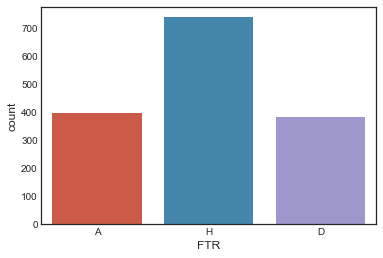

In [30]:
# check frequencies of outcomes in target variable
sns.countplot(x='FTR', data=full) # home team usually wins

print(full['FTR'].value_counts()/full.shape[0]*100) # home team wins 48% of the time; a baseline model that always predicts a home win will hence have about 48% accuracy

In [31]:
##### correct: check for data errors, and correct them if they exist
print(full.describe()) # no obvious errors (e.g. no odds below 1)
print('-'*50)

             B365H        B365D        B365A          BWH          BWD  \
count  1517.000000  1517.000000  1517.000000  1505.000000  1505.000000   
mean      2.460903     3.516823     4.598972     2.410226     3.499542   
std       1.300331     0.742357     2.906385     1.246235     0.757379   
min       1.090000     1.400000     1.100000     1.080000     1.650000   
25%       1.670000     3.100000     2.700000     1.650000     3.100000   
50%       2.100000     3.300000     3.750000     2.050000     3.250000   
75%       2.750000     3.600000     5.500000     2.700000     3.600000   
max      21.000000     9.000000    26.000000    18.000000     9.750000   

               BWA          IWH          IWD          IWA          LBH  \
count  1505.000000  1504.000000  1504.000000  1504.000000  1515.000000   
mean      4.415435     2.347128     3.476995     4.201263     2.354429   
std       2.683272     1.104427     0.665570     2.460836     1.169544   
min       1.100000     1.070000     1

In [32]:
##### complete: impute missing data (if any)

# check for missing data
print('percentage of data that is missing:','\n',full.isnull().sum()/full.shape[0]*100) # not much missing data. target var has no missing values.

# impute missing data with column mean
full.fillna(full.mean(), inplace=True)

percentage of data that is missing: 
 FTR      0.000000
B365H    0.197368
B365D    0.197368
B365A    0.197368
BWH      0.986842
BWD      0.986842
BWA      0.986842
IWH      1.052632
IWD      1.052632
IWA      1.052632
LBH      0.328947
LBD      0.328947
LBA      0.328947
WHH      0.394737
WHD      0.394737
WHA      0.394737
VCH      1.250000
VCD      1.250000
VCA      1.250000
dtype: float64


In [33]:
##### create: engineer some features that may be useful in building the model later
full['mean_odds_home'] = full[['B365H','BWH','IWH','LBH','WHH','VCH']].mean(axis=1)
full['mean_odds_draw'] = full[['B365D','BWD','IWD','LBD','WHD','VCD']].mean(axis=1)
full['mean_odds_away'] = full[['B365A','BWA','IWA','LBA','WHA','VCA']].mean(axis=1)

full['diff_mean_odds_home_draw'] = full['mean_odds_home']-full['mean_odds_draw']
full['diff_mean_odds_away_draw'] = full['mean_odds_away']-full['mean_odds_draw']
full['diff_mean_odds_home_away'] = full['mean_odds_home']-full['mean_odds_away']

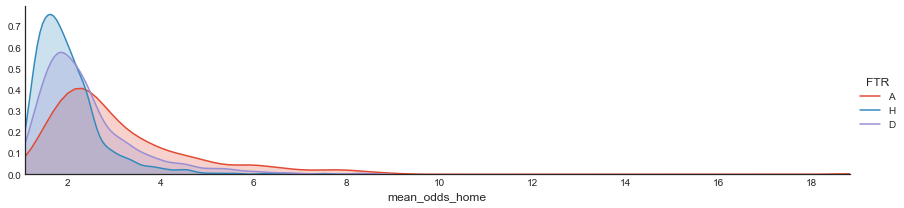

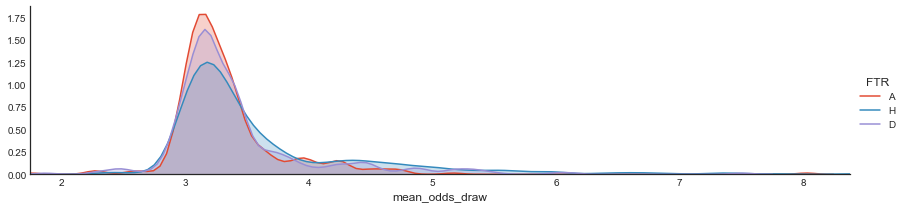

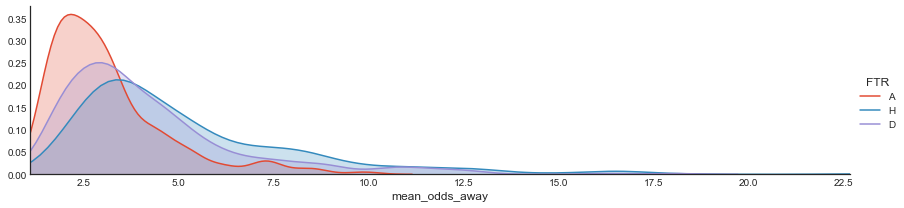

In [34]:
##### data visualizations

# let's see if the distribution of mean_odds_home depends on FTR
a = sns.FacetGrid(full, hue='FTR', aspect=4 ) # use the dataset 'full', and plot one distribution per category of 'FTR'
a.map(sns.kdeplot, 'mean_odds_home', shade= True ) # kernel density plot of mean_odds_home
a.set(xlim=(full['mean_odds_home'].min(), full['mean_odds_home'].max())) # set the boundaries of x-axis
a.add_legend() # add a legend for the distributions

# let's see if the distribution of mean_odds_draw depends on FTR
a = sns.FacetGrid(full, hue='FTR', aspect=4 ) # use the dataset 'full', and plot one distribution per category of 'FTR'
a.map(sns.kdeplot, 'mean_odds_draw', shade= True ) # kernel density plot of mean_odds_draw
a.set(xlim=(full['mean_odds_draw'].min(), full['mean_odds_draw'].max())) # set the boundaries of x-axis
a.add_legend() # add a legend for the distributions

# let's see if the distribution of mean_odds_away depends on FTR
a = sns.FacetGrid(full, hue='FTR', aspect=4 ) # use the dataset 'full', and plot one distribution per category of 'FTR'
a.map(sns.kdeplot, 'mean_odds_away', shade= True ) # kernel density plot of mean_odds_away
a.set(xlim=(full['mean_odds_away'].min(), full['mean_odds_away'].max())) # set the boundaries of x-axis
a.add_legend() # add a legend for the distributions

# seems like betting companies are good at predicting home wins and away wins, but not draws

In [35]:
# split the cleaned full dataset into train and test datasets
from sklearn import model_selection
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(full.drop(['FTR'], axis=1), full['FTR'], test_size=0.3)

In [36]:
##### model building

### view k-fold cross-validation performance of model
from sklearn.ensemble import RandomForestClassifier

my_model1 = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                                   n_estimators = 250, # number of trees
                                   max_features = "sqrt", # number of features to consider at each split
                                   max_depth = 5) # maximum tree depth

cv_results = model_selection.cross_validate(my_model1,
                                            xtrain,
                                            ytrain,
                                            scoring='accuracy',
                                            cv = 10)

print("the mean training accuracy is:", cv_results['train_score'].mean())
print("the mean validation accuracy is:", cv_results['test_score'].mean())

the mean training accuracy is: 0.5839602925809823
the mean validation accuracy is: 0.5366866513842355


In [37]:
##### use random search to optimize the hyperparameters, while building the optimal model concurrently
from scipy.stats import randint
from scipy.stats import uniform

param_dist = {'max_depth': randint(3,15),
              'n_estimators': [250],
              'max_features': ['sqrt']
             }

tune_model = model_selection.RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                                param_distributions=param_dist,
                                                scoring = "accuracy",
                                                cv = 5,
                                                n_iter = 10) # number of iterations of random search

tune_model.fit(xtrain, ytrain)

#print(tune_model.cv_results_['params'])
print('the optimized hyperparameters are: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("after optimization, the mean training accuracy is: {:.4f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_])) 
#print(tune_model.cv_results_['mean_test_score'])
print("after optimization, the mean validation accuracy is: {:.4f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))

the optimized hyperparameters are:  {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 250}
after optimization, the mean training MSE is: 0.5693
after optimization, the mean validation MSE is: 0.5348


0.5789473684210527


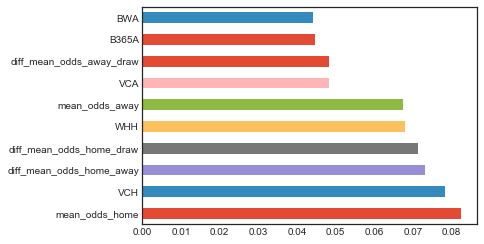

In [38]:
##### use optimized hyperparameters to build random forest
my_rf = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                               n_estimators = tune_model.best_params_['n_estimators'], # number of trees
                               max_features = tune_model.best_params_['max_features'], # number of features to consider at each split
                               max_depth = tune_model.best_params_['max_depth']) # maximum tree depth

# fit the random forest
rf_model1 = my_rf.fit(xtrain,ytrain)

# view feature importances
feature_importances = pd.Series(rf_model1.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# use the fitted model to make predictions
rf_pred1 = rf_model1.predict(xtest)

# test dataset: compare predicted values to actual values
comparison_df = pd.DataFrame({'predicted_FTR': rf_pred1, 
                              'actual_FTR': ytest})
comparison_df['correct_prediction']=0
comparison_df.loc[(comparison_df['predicted_FTR']==comparison_df['actual_FTR']),'correct_prediction']=1
print(comparison_df['correct_prediction'].mean()) # somewhat better accuracy than baseline model

In [39]:
# check if random forest is underpredicting certain categories (e.g. Draw)
for col in comparison_df.columns:
    print(comparison_df[col].value_counts())
    print('-'*50)

# random forest underpredicts Draw, probably because Draw is the rarest outcome and also is inherently unpredictable

H    342
A    111
D      3
Name: predicted_FTR, dtype: int64
--------------------------------------------------
H    228
A    118
D    110
Name: actual_FTR, dtype: int64
--------------------------------------------------
1    264
0    192
Name: correct_prediction, dtype: int64
--------------------------------------------------


In [41]:
# try another simple prediction method: choose the outcome that was assigned the lowest odds (on average) by the companies
xtest['min_mean_odds'] = xtest[['mean_odds_home','mean_odds_draw','mean_odds_away']].min(axis=1)

xtest['pred2'] = np.nan

xtest.loc[(xtest['min_mean_odds']==xtest['mean_odds_home']),'pred2'] = 'H'
xtest.loc[(xtest['min_mean_odds']==xtest['mean_odds_draw']),'pred2'] = 'D'
xtest.loc[(xtest['min_mean_odds']==xtest['mean_odds_away']),'pred2'] = 'A'

comparison2_df = pd.DataFrame({'predicted_FTR': xtest['pred2'], 
                              'actual_FTR': ytest})
comparison2_df['correct_prediction']=0
comparison2_df.loc[(comparison2_df['predicted_FTR']==comparison2_df['actual_FTR']),'correct_prediction']=1
print(comparison2_df['correct_prediction'].mean()) # about the same accuracy as random forest; seems that rf was unneeded here

for col in comparison2_df.columns:
    print(comparison2_df[col].value_counts())
    print('-'*50)

0.5767543859649122
H    342
A    111
D      3
Name: predicted_FTR, dtype: int64
--------------------------------------------------
H    228
A    118
D    110
Name: actual_FTR, dtype: int64
--------------------------------------------------
1    263
0    193
Name: correct_prediction, dtype: int64
--------------------------------------------------
